# Generate Mock Quasar Continua

We show how to generate mock quasar continua here.

In [35]:
import numpy as np
import pandas as pd
import torch
# sbi package for density estimation [https://www.mackelab.org/sbi]
from sbi.inference import SNPE
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['image.cmap'] = 'Greys'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['legend.frameon'] = False
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams["mathtext.fontset"] = 'stix'

Load data here

In [18]:
dataset = pd.read_csv('../data/sdss_catalog.csv', header=0)
dataset.head()

,plate,mjd,fiber,z,lum,h1,h2,h3,h4,h5,h6,h7,h8
0,6741,56394,438,3.081,46.444057,1.714103,-0.684557,-0.148940,0.384972,0.206610,0.738534,0.931790,-0.206453
1,3861,55274,520,2.348,45.819065,0.618451,0.462186,-1.161935,0.212367,-0.199867,-0.852978,-1.632405,-2.789429
2,5480,56001,944,3.418,45.838385,-1.525634,-1.623697,0.458946,-0.841020,-2.089742,0.793837,2.431335,-3.763396
3,4357,55829,436,2.312,46.061531,1.280505,1.419821,1.182550,-0.588393,0.173271,0.901326,-1.379779,-1.131854
4,7152,56660,542,2.752,46.619796,-0.922820,-1.029979,0.588128,2.146219,-0.368286,0.276865,0.393041,-0.189165


In [21]:
h = dataset[[f"h{i}" for i in range(1, 9)]].values
cond = dataset[["z", "lum"]].values
# only use 1000 data points to simplify the problem
h = torch.tensor(h[:1000], dtype=torch.float32)
cond = torch.tensor(cond[:1000], dtype=torch.float32)

In [22]:
# use sbi for density estimation P(h|[z, lum])
inference = SNPE()
inference.append_simulations(h, cond)
density_estimator = inference.train()

 Neural network successfully converged after 90 epochs.

In [31]:
# sample posterior
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((1000,), x=cond[0]).numpy()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

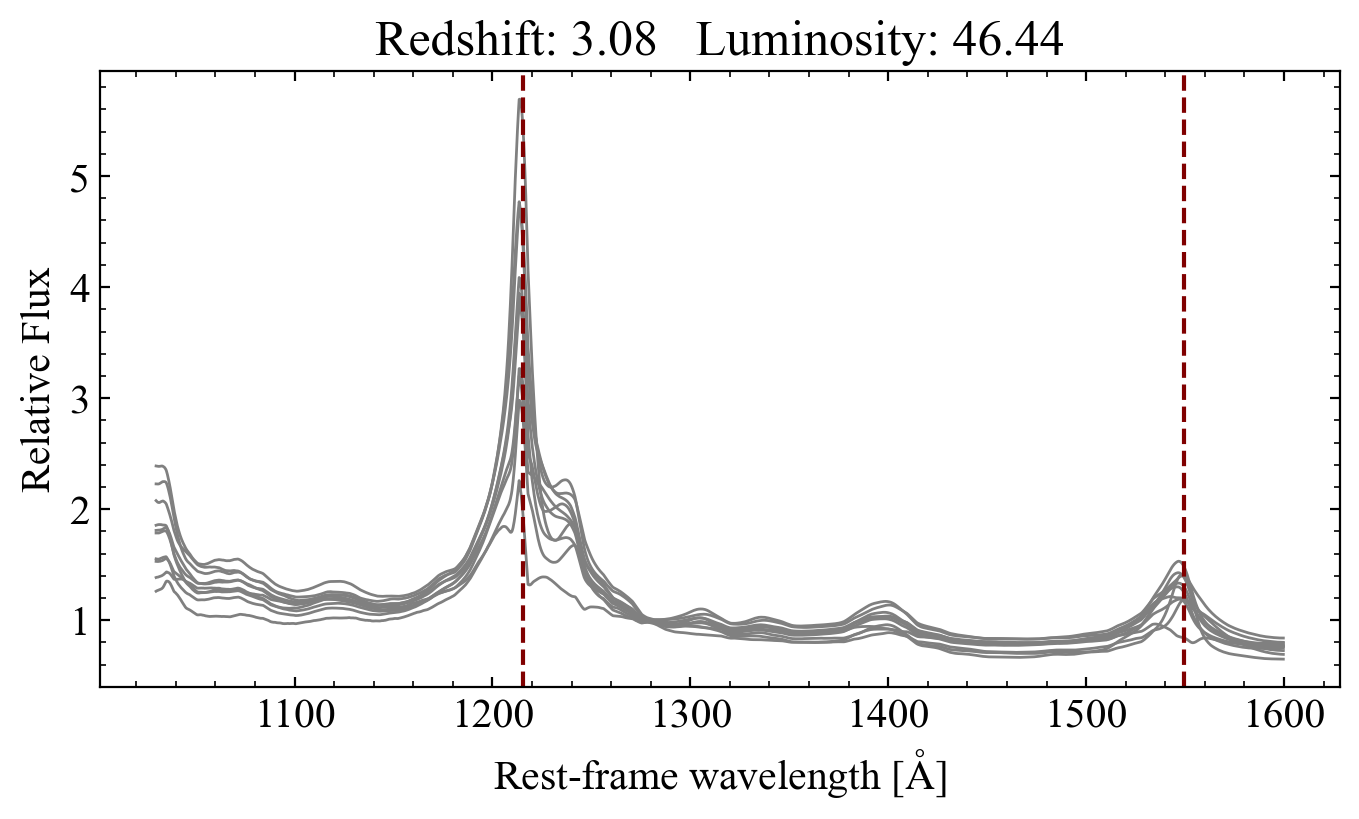

In [42]:
params = np.load('../data/model_parameters.npz')
loglam_min, loglam_max = np.log10(1030.), np.log10(1600.)
loglam = np.arange(loglam_min, loglam_max, 1e-4)
wav = 10**loglam
F, mu = params['F'], params['mu']
_ = plt.figure(figsize=(8, 4))
for _ in range(10):
    idx = np.random.randint(0, 1000)
    _ = plt.plot(wav, F@posterior_samples[idx]+mu, lw=1., color='gray')
_ = plt.xlabel("Rest-frame wavelength [$\mathrm{\AA}$]")
_ = plt.ylabel("Relative Flux")
_ = plt.title(f"Redshift: {cond[0][0]:.2f}   Luminosity: {cond[0][1]:.2f}")
_ = plt.axvline(x=1215.67, color='maroon', linestyle='--')
_ = plt.axvline(x=1549.5, color='maroon', linestyle='--')